# 非线性激活函数量化——查表法

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [35]:
# 量化比特数
bit_nums = 8
# lut表大小
lut_size = 256

q_min = 0
q_max = 2 ** bit_nums - 1

in_scale = 20 / (2 ** bit_nums - 1)
in_zp = np.clip(np.round(q_max - 10 / in_scale), q_min, q_max)
out_scale = 1 / (2 ** bit_nums - 1)
out_zp = np.clip(np.round(q_max - 1 / out_scale), q_min, q_max)

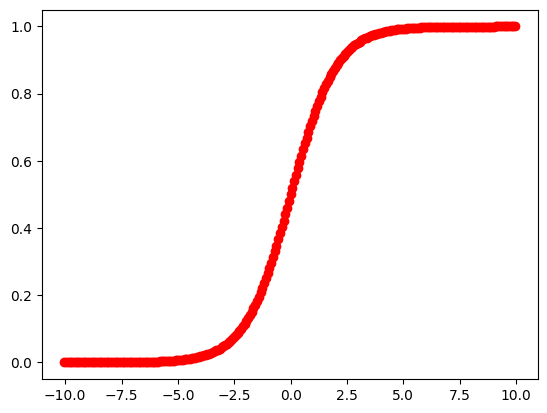

In [36]:
# 生成 lut 表的采样点
q_x = np.round(np.linspace(0, 2 ** bit_nums - 1, lut_size))
# 反量化到 [-10, 10]
x = (q_x - in_zp) * in_scale
# 计算 sigmoid 函数的值
y = sigmoid(x)
# 函数值量化到 [0, 255]
q_y = np.clip(np.round(y / out_scale) + out_zp, q_min, q_max)
plt.plot(x, y, 'ro')

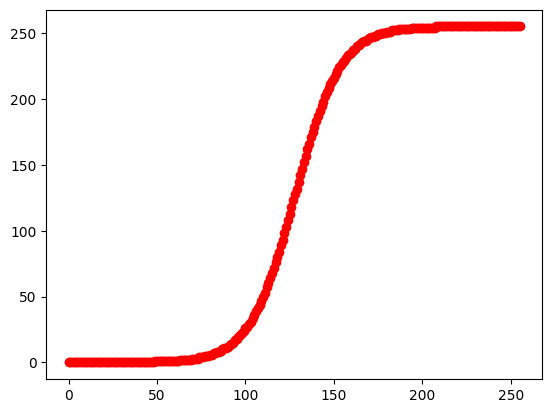

In [37]:
plt.plot(q_x, q_y, 'ro')

## 推理阶段

In [38]:
x=2
q_x1=np.round(x/in_scale)+in_zp
y=np.interp(q_x1, q_x, q_y)
print(y)
y=(y-out_zp)*out_scale
print(y)

226.0
0.8862745098039215


In [39]:
print(sigmoid(2))

0.8807970779778823


## 非线性函数电路

In [40]:
from concrete import fhe
import numpy as np

In [41]:
table = fhe.LookupTable(q_y.astype(np.int32))

@fhe.compiler({"q_x": "encrypted"})
def q_sigmoid(q_x):
    return table[q_x]

inputset = range(0,256)
circuit = q_sigmoid.compile(inputset)

print(circuit)

%0 = q_x                                             # EncryptedScalar<uint8>        ∈ [0, 255]
%1 = tlu(%0, table=[  0   0   ... 5 255 255])        # EncryptedScalar<uint8>        ∈ [0, 255]
return %1


In [42]:
x=2
q_x1=(np.round(x/in_scale)+in_zp).astype(np.int32)

In [43]:
y=circuit.encrypt_run_decrypt(q_x1)

In [44]:
y=(y-out_zp)*out_scale
print(y)

0.8862745098039215


In [45]:
print(q_x)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [46]:
print(q_y)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   2.   2.   2.   2.   2.   2.   2.
   3.   3.   3.   3.   4.   4.   4.   5.   5.   5.   6.   6.   7.   7.
   8.   8.   9.  10.  11.  11.  12.  13.  14.  15.  17.  18.  19.  21.
  22.  24.  26.  27.  29.  31.  34.  36.  39.  41.  44.  47.  50.  53.
  57.  60.  64.  68.  72.  76.  80.  84.  89.  93.  98. 103. 108. 113.
 118. 123. 128. 132. 137. 142. 147. 152. 157. 162. 166. 171. 175. 179.
 183. 187. 191. 195. 198. 202. 205. 208. 211. 214. 216. 219. 221. 224.
 226. 228. 229. 231. 233. 234. 236. 237. 238. 240. 241. 242. 243. 244.
 244. 245. 246. 247. 247. 248. 248. 249. 249. 250. 250. 250. 251. 251.
 251. 252. 252. 252. 252. 253. 253. 253. 253. 253. 253. 253. 254. 254.
 254. 